We first import necessary packages.

In [1]:
!pip install gymnasium==0.29.0
!pip install rlcard==1.0.9

In [2]:
import numpy as np

import gymnasium as gym
import rlcard

import matplotlib.pyplot as plt

# Blackjack
Next, we instantiate the [Blackjack](https://rlcard.org/games.html#blackjack) game implemented as part of the [RL Card](https://rlcard.org/overview.html) toolkit and gain a quick understanding of its key variables and methods.

Blackjack is a globally popular card game also known as Twenty-One. The objective of the player (agent) is to beat the dealer by reaching a higher score than the dealer without exceeding 21. All face cards (Jack, Queen, King) count as 10 and an ace can count either as 1 or 11. All remaining cards (2 through 10) count as the number shown on the card.

The developers of RL Card toolkit have implemented a simple version of Blackjack. The game begins with two cards dealt to both the dealer and player. The player can see both of their cards but only one of the dealer's cards. In each round, the player has two options: `hit` which will add a card to their hand, and `stand` which will end their turn.

The player will `bust` if their hands exceed 21 points. The player loses the game if they go bust. After the player completes their hands (chooses `stand` and has not busted), the dealer then reveals their hidden card and plays `hit` until obtaining at least 17 points. If the dealer goes bust, then the player wins; otherwise, the outcome is determined by whose final sum is closer to 21. The person whose final sum is closest to 21 wins the game. If both players have the same score than the game is tied. The RL Card environment models the player's rewards as -1 (lose), 0 (tie), or 1 (win) received at the end of the game.

Follow the hyperlinks to learn more about the envionment [Blackjack](https://rlcard.org/games.html#blackjack) and its [source code](https://github.com/datamllab/rlcard/tree/master/rlcard).

#### MDP Environment
We first write a Gymnasium wrapper for the blackjack environment to represent it as a single-agent MDP. This allows us to use a similar syntax and environment API as that for Frozen Lake (and other Gymnasium environments).

In [3]:
class BlackjackEnv(gym.Env):
    """Wraps Blackjack as an OpenAI Gym environment."""

    def __init__(self):
        """Defines Action and Observation Spaces for the environment"""
        self._rlcard_env = rlcard.make('blackjack')
        self.action_space = gym.spaces.Discrete(self._rlcard_env.num_actions)
        self.observation_space = gym.spaces.Box(0, 31, shape=self._rlcard_env.state_shape[0], dtype=np.int32)

    def seed(self, seed):
        """Seed for generation of random behavior."""
        self._rlcard_env.seed(seed)

    def reset(self):
        """Resets the environment to an initial state and returns the initial observation."""
        obs, _ = self._rlcard_env.reset()
        obs = tuple(obs["obs"].tolist())
        return obs

    def step(self, action):
        """Run one timestep of the environment's dynamics.

        Args:
            action: an action provided by the agent

        Returns:
            observation: an observation provided by the environment
            reward (float): the reward returned as a result of taking the action
            terminated (bool): whether a terminal state is reached
            info (dictionary): an empty dictionary to conform to gym.Env
        """
        obs, _ = self._rlcard_env.step(action)
        obs = tuple(obs["obs"].tolist())
        done = False
        reward = 0.0
        if self._rlcard_env.is_over():
            done = True
            reward = float(self._rlcard_env.get_payoffs()[0])
        return obs, reward, done, {}

In [4]:
env = BlackjackEnv()

In [5]:
env.observation_space

Box(0, 31, (2,), int32)

#### States

OpenAI Gymnasium environments do not explicitly provide state but instead provide observation. In the Blackjack environment, the state and observation are identical. In practice, the design of state can require some feature engineering for using RL techniques.

In this environment, we design the state as an array of two features `[player_score, dealer_score]` where `player_score` is the score currently obtained by the player, and the `dealer_score` is derived from the card that faces up from the dealer. Think about why this is an appropriate definition of the state.

In [6]:
print(f"Number of state features: {env.observation_space.shape}")
print(f"Lowest value for the player_score feature: {env.observation_space.low[0]}")
print(f"Highest value for the player_score feature: {env.observation_space.high[0]}")
print(f"Lowest value for the dealer_score feature: {env.observation_space.low[1]}")
print(f"Highest value for the dealer_score feature: {env.observation_space.high[1]}")

Number of state features: (2,)
Lowest value for the player_score feature: 0
Highest value for the player_score feature: 31
Lowest value for the dealer_score feature: 0
Highest value for the dealer_score feature: 31


#### Actions
There are two actions in the simple Blackjack. They are encoded as follows:
- 0 denotes `hit` and
- 1 denotes `stand`

In [7]:
print(f"Number of actions: {env.action_space.n}")

Number of actions: 2


#### Transition and Reward Function

The transition and reward functions for the Blackjack environment are not explicitly represented as matrices or tensors. This is typical for practical RL environments, as tabular representation of these functions can be memory intensive. Instead the gymnasium API provides access to the `step` method, which takes in as input an `action` and provides (among other things) an `observation` and `reward`. Also notice the `reset` method, which resets the MDP environment.

The following snippet describes the use of `step` and `reset` methods.

In [8]:
# Reset the environment
state = env.reset()
print(f"State: {state}")

# Select a random action to play
action = env.action_space.sample()
print(f"Action: {action}")

# Send this action to the environment to receive the next state and reward
next_state, reward, episode_completed, _ = env.step(action)
print(f"Next state: {next_state}")
print(f"Reward: {reward}")

State: (17, 11)
Action: 1
Next state: (17, 21)
Reward: -1.0


#### Agent
In the code snippet above, we chose a random action to play and then saw its effect. This code snippet demonstrates implementation of an agent that acts in the Blackjack environment based on a random policy. In practice, we want to do better than random by using the state information and RL algorithms to select a action that leads to maximum value.

Your goal is in this problem is to design two such agents. One using Monte Carlo methods and the other using Temporal Difference methods. To help you design these agents, we provide an agent base class that includes helper methods to collect data from the environment.

In [9]:
class AgentBase:
    def __init__(self, env):
        self.env = env
        self.num_actions = self.env.action_space.n
        self.policy = self.make_policy()
        self.behavior_policy = self.make_behavior_policy()

    def make_policy(self):
        """
        Return a policy function that will be used for evaluation. The policy
        takes observation as input and return action
        """
        raise NotImplementedError

    def make_behavior_policy(self):
        """
        Similar to make_policy, it returns a policy function. But this one used
        for interaction with the environment.
        """
        raise NotImplementedError

    def run_episode(self, episode_policy):
        """
        Generate one episode with the given policy
        """
        episode = []
        done = False
        obs = self.env.reset()
        episode_return = 0
        while not done:
            action = episode_policy(obs)
            next_obs, reward, done, _ = self.env.step(action)
            episode.append([obs, action, reward, next_obs, done])
            obs = next_obs
            episode_return += reward

        return (episode, episode_return)

    def evaluate(self, num_eval_episodes=1000, plot_title="Evaluation"):
        """Evaluates the agent."""
        list_returns = []
        list_average_returns = []
        average_return = 0
        for episode_idx in range(num_eval_episodes):
            _, episode_return = self.run_episode(self.policy)
            average_return += (1. / (episode_idx+1)) * (episode_return - average_return)
            list_returns.append(episode_return)
            list_average_returns.append(average_return)

        print(f"Average reward {round(average_return, 3)}")
        plt.plot(list_returns,'^',label="Return")
        plt.plot(list_average_returns,'r',label="Average Return")
        plt.ylabel('Return')
        plt.xlabel('Episode#')
        plt.title(plot_title)
        plt.legend()
        plt.ylim(-1.05, 1.05)
        plt.show()

Next, we will implement the first-visit Monte Carlo method to compute the optimal policy for Blackjack.

In [10]:
from collections import defaultdict
import numpy as np
import random
class MonteCarlo(AgentBase):
    def __init__(self, env):
        super().__init__(env=env)
        self.gamma = 0.99 # Assume a discount factor of 0.99
        # Put your required variable here
        self.epsilon = 0.1
        self.Q = defaultdict(lambda: np.zeros(self.num_actions))
        self.Returns = defaultdict(list)

    def make_policy(self):
        def policy_func(observation):
            return np.argmax(self.Q[observation])
        return policy_func

    def make_behavior_policy(self):
        def policy_func(observation):
            
            best_action = np.argmax(self.Q[observation])
        
            action_prob = []
            for action in range(self.num_actions):
                if action == best_action:
                    a_prob = 1 - self.epsilon + self.epsilon / self.num_actions
                else:
                    a_prob = self.epsilon / self.num_actions
                action_prob.append(a_prob)

            return np.random.choice(np.arange(self.num_actions), p=action_prob)

        return policy_func

    def update(self, episode):
        """
        Update the agent given episodes
        """
        # Calculate the discounted cumulative rewards
        G = 0

        for t in range(len(episode) - 1, -1, -1):
            s, a, reward,_ ,_ = episode[t]
            G = self.gamma * G + reward
            
            if not any([x[0] == s and x[1] == a for x in episode[:t]]):
                self.Returns[(s, a)].append(G)
                self.Q[s][a] = np.mean(self.Returns[(s, a)])

    def train(self, num_train_episodes, make_plot=False):
        list_returns = []
        list_average_returns = []
        average_return = 0
        for episode_idx in range(num_train_episodes):
            # First, generate an episode with behavior policy
            episode, episode_return = self.run_episode(self.behavior_policy)

            # Second, update the policy with the data collected during the episode
            self.update(episode)

            # Store the return for evaluation
            list_returns.append(episode_return)
            average_return += (1. / (episode_idx+1)) * (episode_return - average_return)
            list_average_returns.append(average_return)

        if make_plot:
            plt.plot(list_returns,'^',label="Return")
            plt.plot(list_average_returns,'r',label="Average Return")
            plt.ylabel('Return')
            plt.xlabel('Episode#')
            plt.title('Performance during training')
            plt.legend()
            plt.show()

#### Grader Code
Report the output of the grader code in your pdf submission.

In [11]:
env = BlackjackEnv()
agent = MonteCarlo(env)

Average reward -1.0


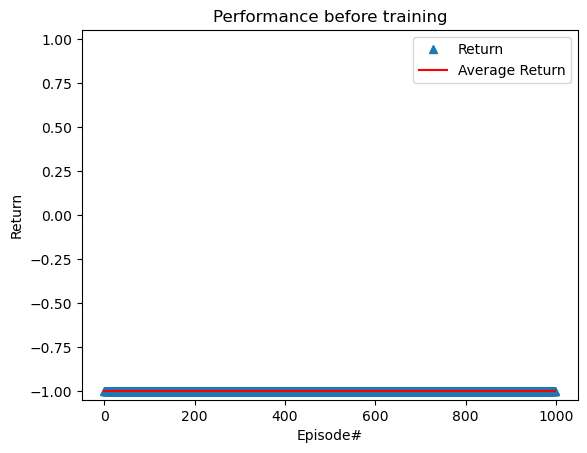

In [12]:
agent.evaluate(plot_title="Performance before training")

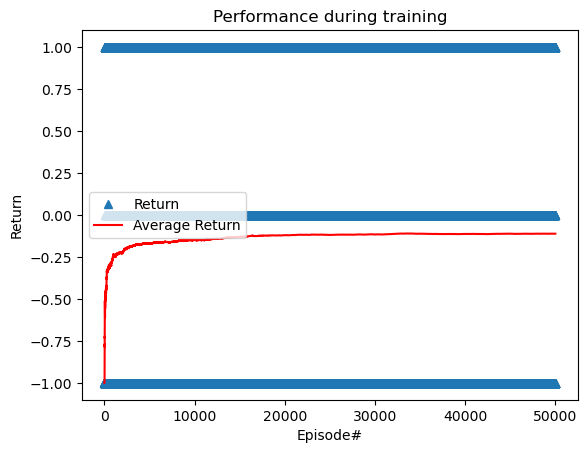

In [13]:
agent.train(50000, make_plot=True)

Average reward -0.091


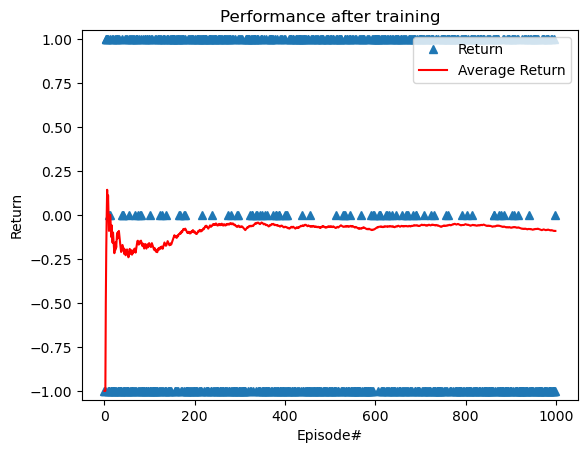

In [14]:
agent.evaluate(plot_title="Performance after training")